# 程式 9.1 （虛擬碼）

In [ ]:
# 初始化所有代理人的動作
# for j in agents: #走訪環境中所有代理人（儲存於串列中）
#   state = environment.get_state() #取得環境目前的狀態
#   neighbors = get_neighbors(j, num=3) #找出距離代理人j最近的3個代理人
#   joint_action = get_joint_action(neighbors) #傳回代理人j附近代理人的聯合動作
#   q_values = Q(state, joint_action) #給定狀態與鄰居的聯合動作，取得代理人j的動作Q值
#   j.action = policy(q_values) #接受各動作的Q值後，傳回一個離散動作
#   environment.take_action(j.action)
#   reward = environment.get_reward()

# 程式 9.2 （虛擬碼）

In [ ]:
# 初始化所有代理人的動作

# for m in range(M): #重複計算M次，以降低最初的隨機性
#   for j in agents:
#     state = environment.get_state()
#     neighbors = get_neighbors(j, num=3) #找出離代理人j最近的3個鄰居
#     joint_actions = get_joint_action(neighbors) #建立鄰居的聯合動作空間
#     q_values = Q(state, joint_actions) #根據鄰居的聯合動作空間及當前狀態，計算各動作Q值
#     j.action = policy(q_values) #選擇動作

# for j in agents: #走訪每位代理人，執行在以上迴圈中最後一輪所計算出的動作
#   environment.take_action(j.action)
#   reward = environment.get_reward()

In [ ]:
import torch
a = torch.Tensor([1,0,0,0])#創建向量a
print(a.shape)
b = a.reshape(4,1) #將向量a reshape成矩陣b
print(b.shape)

torch.Size([4])
torch.Size([4, 1])


In [ ]:
 import numpy as np
 np.array([[0,0,0,1]]).T @ np.array([[0,1,0,0]]) #用T（）對numpy陣列進行轉置

array([[0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 1, 0, 0]])

In [ ]:
z = np.array([[0,0,0,1]]).T @ np.array([[0,1,0,0]])
z.flatten() #使用flatten()將矩陣z扁平化成向量

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0])

# 程式 9.3： （1D Ising模型）產生格狀結構與回饋值

In [ ]:
import numpy as np
import torch
from matplotlib import pyplot as plt

def init_grid(size=(10,)): 
  grid = torch.randn(*size) #產生長度為10的1D Ising模型（每個元素為一個隨機數）
  grid[grid > 0] = 1  #若元素值大於0，則將該元素設為1（代表向上自旋）
  grid[grid <= 0] = 0 #若元素值小於/等於0，則將該元素設為0（代表向下自旋）
  grid = grid.byte() #將浮點數轉換成位元組（byte）物件，使其變成二元數
  return grid

def get_reward(s,a): #s是某個代理人a的鄰居串列
  r = -1 #初始化回饋值為-1
  for i in s:
    if i == a: #如果陣列s中的值（自旋方向）與a的自旋方向相同，則回饋值+0.9
      r += 0.9
  return r

In [ ]:
size = (20,)
grid = init_grid(size=size) #初始化一個長度為20的方格
grid

tensor([1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0],
       dtype=torch.uint8)

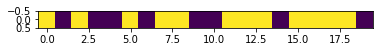

In [ ]:
plt.imshow(np.expand_dims(grid,0))

# 程式 9.4： （1D Ising模型）產生神經網路的參數

In [ ]:
def gen_params(N,size): #N代表代理人數目，size代表一個代理人的神經網路參數數量
  ret = [] #編註：這裡的ret和前面幾章的回報（Return）是不同的東西，讀者不要搞混了
  for i in range(N):
    vec = torch.randn(size) / 10.
    vec.requires_grad = True
    ret.append(vec) #將第i個代理人的神經網路參數存進ret
  return ret #傳回所有代理人的網路參數

# 程式 9.5：（1D Ising模型）定義Q函數

In [ ]:
def qfunc(s,theta,layers=[(4,20),(20,2)],afn=torch.tanh):
  l1n = layers[0] #取出第一層神經層的shape
  l1s = np.prod(l1n) #取layers中的第一個tuple，再將其中的數字相乘，得到第一層神經層的參數數量
  theta_1 = theta[0:l1s].reshape(l1n) #將theta向量的子集轉換成矩陣，做為第一層神經層的參數矩陣
  l2n = layers[1]
  l2s = np.prod(l2n)
  theta_2 = theta[l1s:l2s+l1s].reshape(l2n)
  bias = torch.ones((1,theta_1.shape[1])) # 加上一個偏值的張量 
  l1 = s @ theta_1 + bias #此為第一層神經層所執行的計算，s是shape為(4,1)的聯合動作向量
  l1 = torch.nn.functional.elu(l1)
  l2 = afn(l1 @ theta_2) #採用tanh做為激活函數，將輸出值限制在[-1,1]
  return l2.flatten() #傳回扁平化後的l2

# 程式 9.6： （1D Ising模型）取得環境的狀態

In [ ]:
def get_substate(b): #將一個二元數字轉換為one-hot編碼的動作向量，如[0,1]
  s = torch.zeros(2) #將動作向量s初始化為[0,0]
  if b != 0: #若輸入不等於0，則動作向量為[0,1]（向上），否則動作向量為[1,0]（向下）
    s[1] = 1
  else:
    s[0] = 1
  return s

def joint_state(n): #n為具有兩個元素的向量，其中，n[0]=左方鄰居，n[1]=右方鄰居
  n1_ = get_substate(n[0]) #取得左右鄰居的one-hot動作向量
  n2_ = get_substate(n[1])
  ret = (n1_.reshape(2,1) @ n2_.reshape(1,2)).flatten() #使用外積@產生聯合動作向量，並把結果扁平化為向量
  return ret

# 程式 9.7： （1D Ising模型）初始化方格

tensor([1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0],
       dtype=torch.uint8)


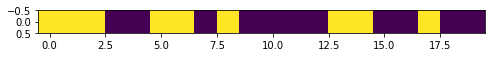

In [ ]:
plt.figure(figsize=(8,5))
size = (20,) #將方格的大小設定為長度20的向量（20個代理人）
hid_layer = 20 #設定隱藏層的寬度，由於我們的Q函數只有兩層（不包含輸入層），故隱藏層只會有一層
params = gen_params(size[0],4*hid_layer+hid_layer*2) #產生20個代理人的參數向量
grid = init_grid(size=size)
grid_ = grid.clone() #將方格複製一份（在程式9.8時會用到）
print(grid)
plt.imshow(np.expand_dims(grid,0))

# 程式 9.8：（1D Ising模型）訓練迴圈

In [ ]:
epochs = 200
lr = 0.001 #學習率
losses = [[] for i in range(size[0])] #儲存每個代理人的損失串列
for i in range(epochs):
  for j in range(size[0]): #走訪每一位代理人
    l = j - 1 if j - 1 >= 0 else size[0]-1 #取得左方鄰居的資料(若代理人位於模型最左端，則左方鄰居為模型最右端的代理人)
    r = j + 1 if j + 1 < size[0] else 0 #取得右方鄰居的資料（若代理人位於模型最右端，則右方鄰居為模型最左端的代理人）
    state_ = grid[[l,r]] #state_由兩個二元數字組成，分別代表左右鄰居的自旋方向
    state = joint_state(state_) #state_中包含兩位代理人的二元動作向量，將此向量轉換為one-hot聯合動作向量
    qvals = qfunc(state.float().detach(),params[j], layers=[(4,hid_layer) , (hid_layer,2)])
    qmax = torch.argmax(qvals,dim=0).detach().item() #此處的策略是執行Q值最高的動作
    action = int(qmax)
    grid_[j] = action #我們在程式9.7複製的方格grid_中執行動作，當所有代理人都執行完動作後，才將grid_的最新結果複製給主要方格grid
    reward = get_reward(state_.detach(),action)
    with torch.no_grad(): #{3}將原本的Q值向量複製一份，將與執行動作有關的Q值替換成實際回饋值後，當成目標Q值向量
      target = qvals.clone()
      target[action] = reward
    loss = torch.sum(torch.pow(qvals - target,2))
    losses[j].append(loss.detach().numpy())
    loss.backward()
    with torch.no_grad(): #手動進行梯度下降
      params[j] = params[j] - lr * params[j].grad
    params[j].requires_grad = True
  with torch.no_grad(): #將grid_中的暫存資料複製到grid向量中
    grid.data = grid_.data

tensor([1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
       dtype=torch.uint8) tensor(17)


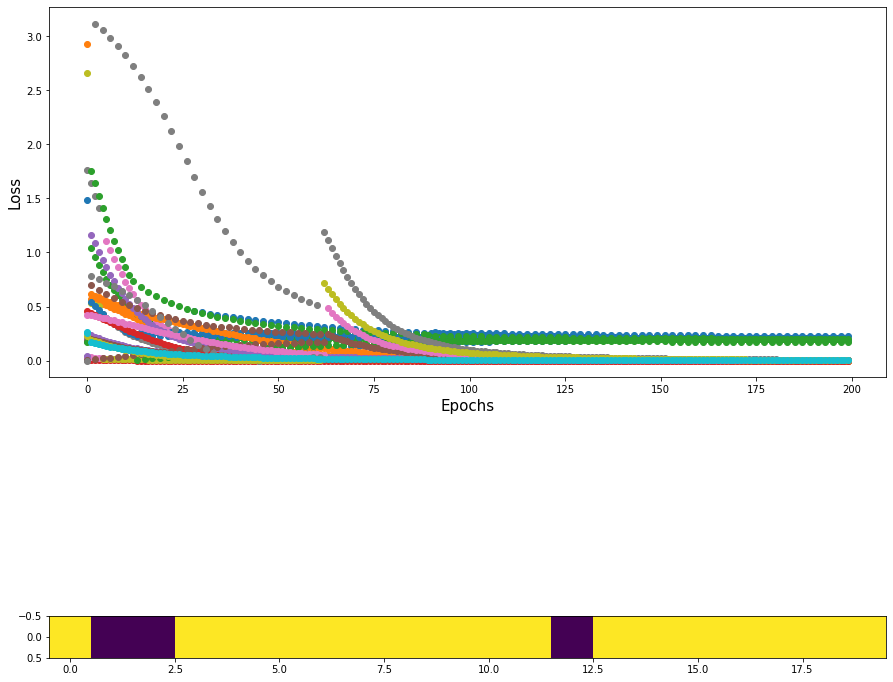

In [ ]:
fig,ax = plt.subplots(2,1,figsize=(15,15))
for i in range(size[0]):
  ax[0].scatter(np.arange(len(losses[i])),losses[i])
ax[0].set_xlabel("Epochs",fontsize=15)
ax[0].set_ylabel("Loss",fontsize=15)
print(grid,grid.sum())
ax[1].imshow(np.expand_dims(grid,0))

# 程式 9.9： （平均場Q-Learning) 策略函數

In [ ]:
from collections import deque 
from random import shuffle 

def softmax_policy(qvals,temp=0.9): #此策略函數會接受Q值向量，並傳回一特定動作
  soft = torch.exp(qvals/temp) / torch.sum(torch.exp(qvals/temp)) #softmax函數的定義
  action = torch.multinomial(soft,1) #依據動作的機率分佈來隨機抽選一個動作
  return action

# 程式 9.10：（平均場Q-Learning）傳回座標與回饋值的函式

In [ ]:
def get_coords(grid,j): #從方格中取得索引值，並推算原始的[x,y]座標，j為代理人的索引
  x = int(np.floor(j / grid.shape[0])) #找出x座標，grid.shape[0]為方2D方格的邊長
  y = int(j - x * grid.shape[0]) #找出y座標
  return x,y

def get_reward_2d(action,action_mean): #2D方格的回饋值函式
  r = (action*(action_mean-action/2)).sum()/action.sum() #根據代理人動作和平均場動作之間的差異，計算回饋值
  return torch.tanh(5 * r) #使用tanh將回饋值的範圍轉換成[-1,1]

In [ ]:
get_reward_2d(torch.Tensor([1,0]),torch.Tensor([0.25, 0.75]))

tensor(-0.8483)

In [ ]:
get_reward_2d(torch.Tensor([0,1]),torch.Tensor([0.25, 0.75]))

tensor(0.8483)

# 程式 9.11：（平均場Q-Learning）計算平均動作向量

In [ ]:
def mean_action(grid,j):
  x,y = get_coords(grid,j) #將向量的索引j變回座標[x,y]，其中[0,0]代表方格的左上角
  action_mean = torch.zeros(2) 
  for i in [-1,0,1]: #設定鄰居在x方向及y方向上與代理人j的距離範圍
    for k in [-1,0,1]:
      if i == k == 0: #若x方向及y方向的距離皆為0，則代表代理人j自己，直接跳過
        continue
      x_,y_ = x + i, y + k #該鄰居的x座標為代理人的x座標+i；y座標為代理人j的y座標+k
      x_ = x_ if x_ >= 0 else grid.shape[0] - 1 #計算鄰居的座標，把代理人j位於角落時的狀況考慮進去，對其鄰居座標加以處理
      y_ = y_ if y_ >= 0 else grid.shape[1] - 1
      x_ = x_ if x_ <  grid.shape[0] else 0
      y_ = y_ if y_ < grid.shape[1] else 0
      cur_n = grid[x_,y_] #將鄰居的自旋方向存進cur_n
      s = get_substate(cur_n) #利用鄰居的座標取得其動作向量
      action_mean += s
  action_mean /= action_mean.sum() #將動作向量正規化，形成各動作的機率分佈
  return action_mean

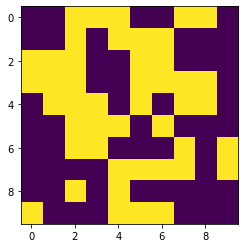

In [ ]:
size = (10,10) #設定方格板的大小為10×10
J = np.prod(size) #計算代理人總數
hid_layer = 10
layers = [(2,hid_layer),(hid_layer,2)] #兩個神經層的shape
params = gen_params(1,2*hid_layer+hid_layer*2) #產生參數向量
grid = init_grid(size=size)
grid_ = grid.clone()
grid__ = grid.clone()
plt.imshow(grid) #畫出隨機初始化的2D Ising模型

# 程式 9.12：（平均場Q-Learning）主要訓練迴圈

In [ ]:
epochs = 75
lr = 0.0001
num_iter = 3 #重複計算的次數（為了消除初始平均場動作的隨機性）
replay_size = 50 #經驗池中的經驗資料總數
replay = deque(maxlen=replay_size) #經驗池的資料型態為deque 
batch_size = 10 #將小批次量設為10，代表我們會隨機從經驗池中選取10筆資料來進行訓練
gamma = 0.9 #削減因子
losses = [[] for i in range(J)] #儲存每位代理人的損失串列

for i in range(epochs): 
  act_means = torch.zeros((J,2)) #初始化用來儲存平均場動作的張量
  q_next = torch.zeros(J) #儲存新狀態Q值的張量
  for m in range(num_iter): 
    for j in range(J): #走訪方格中的所有代理人
      action_mean = mean_action(grid_,j).detach()
      act_means[j] = action_mean.clone() #將代理人的平均場向量存進act_means
      qvals = qfunc(action_mean.detach(),params[0],layers=layers)
      action = softmax_policy(qvals.detach(),temp=0.5)
      grid__[get_coords(grid_,j)] = action
      q_next[j] = torch.max(qvals).detach()
    grid_.data = grid__.data
  grid.data = grid_.data
  actions = torch.stack([get_substate(a.item()) for a in grid.flatten()])
  rewards = torch.stack([get_reward_2d(actions[j],act_means[j]) for j in range(J)])
  exp = (actions,rewards,act_means,q_next) #{2}搜集經驗資料，並儲存到經驗池中
  replay.append(exp)
  shuffle(replay) #將經驗池內的經驗進行洗牌
  if len(replay) > batch_size: #當經驗池中的資料大於批次量參數（batch_size）時，啟動訓練程序
    ids = np.random.randint(low=0,high=len(replay),size=batch_size) #產生一系列隨機索引值
    exps = [replay[idx] for idx in ids] #利用隨機索引值從經驗池中抽取訓練批次
    for j in range(J):
      jacts = torch.stack([ex[0][j] for ex in exps]).detach()
      jrewards = torch.stack([ex[1][j] for ex in exps]).detach()
      jmeans = torch.stack([ex[2][j] for ex in exps]).detach()
      vs = torch.stack([ex[3][j] for ex in exps]).detach()
      qvals = torch.stack([ qfunc(jmeans[h].detach(),params[0],layers=layers) for h in range(batch_size)])
      target = qvals.clone().detach()
      target[:,torch.argmax(jacts,dim=1)] = jrewards + gamma * vs
      loss = torch.sum(torch.pow(qvals - target.detach(),2))
      losses[j].append(loss.item())
      loss.backward()
      with torch.no_grad():
        params[0] = params[0] - lr * params[0].grad
      params[0].requires_grad = True

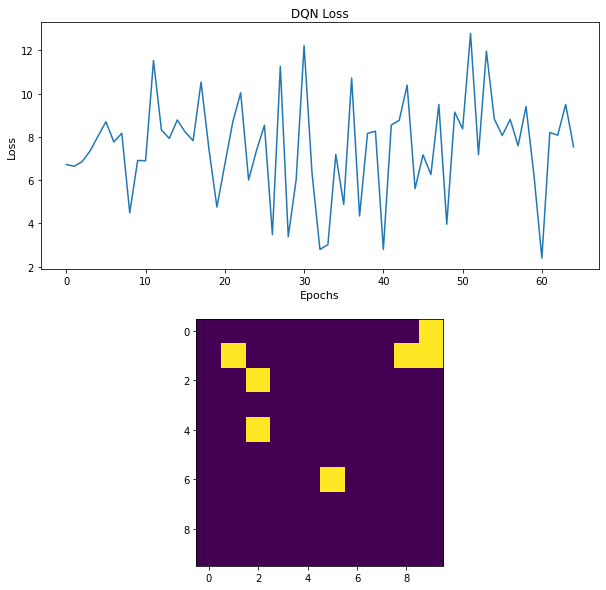

In [ ]:
fig,ax = plt.subplots(2,1)
fig.set_size_inches(10,10) 
ax[0].plot(np.array(losses).mean(axis=0))
ax[0].title.set_text('DQN Loss')
ax[0].set_xlabel("Epochs",fontsize=11)
ax[0].set_ylabel("Loss",fontsize=11)
ax[1].imshow(grid)

In [ ]:
pip install magent

     |████████████████████████████████| 1.7MB 22.6MB/s 
     |████████████████████████████████| 11.8MB 48.3MB/s 


# 程式 9.13: 建立MAgent環境

In [ ]:
import magent
import math
from scipy.spatial.distance import cityblock 

map_size = 30
env = magent.GridWorld("battle", map_size=map_size) #將環境模式設定為『battle（對戰）』，並把Gridworld方格板的大小設為30 x 30
team1, team2 = env.get_handles() #初始化兩個隊伍

# 程式 9.14： 加入代理人

In [ ]:
hid_layer = 25
in_size = 359
act_space = 21
layers = [(in_size,hid_layer),(hid_layer,act_space)] #設定各神經層的shape參數
params = gen_params(2,in_size*hid_layer+hid_layer*act_space) #產生兩個DQN模型的參數向量

map_size = 30
width = height = map_size
n1 = n2 = 16 #將每個陣營的代理人數量設為16
gap = 1 #設定代理人的初始間隔距離
epochs = 1000
replay_size = 70
batch_size = 25
side1 = int(math.sqrt(n1)) * 2
pos1 = []
for x in range(width//2 - gap - side1, width//2 - gap - side1 + side1, 2): #產生team1代理人（在方格板左半邊）的位置，//代表floor division
  for y in range((height - side1)//2, (height - side1)//2 + side1, 2):
    pos1.append([x, y, 0])

side2 = int(math.sqrt(n2)) * 2
pos2 = []
for x in range(width//2 + gap, width//2 + gap + side2, 2): #產生team2代理人（在方格板右半邊）的位置
  for y in range((height - side2)//2, (height - side2)//2 + side2, 2):
    pos2.append([x, y, 0])
        
env.reset()
env.add_agents(team1, method="custom", pos=pos1) #根據之前產生的位置串列，將team1代理人加入到方格板上
env.add_agents(team2, method="custom", pos=pos2)

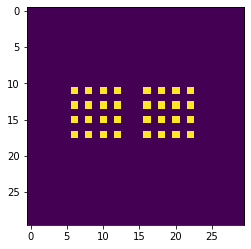

In [ ]:
plt.imshow(env.get_global_minimap(30,30)[:,:,:].sum(axis=2))

# 程式 9.15： 找出鄰居

In [ ]:
def get_neighbors(j,pos_list,r=6): #接收了包含所有代理人位置的pos_list後，傳回以代理人j為中心，半徑r以內的代理人索引值
  neighbors = []
  pos_j = pos_list[j] #將代理人j的位置存進pos_j
  for i,pos in enumerate(pos_list):
    if i == j:
      continue
    dist = cityblock(pos,pos_j)#比較pos及pos_j之間的距離
    if dist < r:
      neighbors.append(i) #將半徑r內的代理人索引存進neighbors串列中
  return neighbors

In [ ]:
get_neighbors(5,env.get_pos(team1))

[0, 1, 2, 4, 6, 7, 8, 9, 10, 13]

# 程式 9.16： 計算平均場動作向量

In [ ]:
def get_onehot(a,l=21): #將動作的整數索引轉換為one-hot動作向量,a為所選擇的動作索引
  x = torch.zeros(21)
  x[a] = 1
  return x

def get_scalar(v): #將one-hot動作向量轉換為整數索引
  return torch.argmax(v)

def get_mean_field(j,pos_list,act_list,r=6,l=21): #計算代理人j的平均場動作，其中pos_list是各代理人的座標值，act_list記錄了各代理人選擇之動作索引，而l則代表動作空間的維度
  neighbors = get_neighbors(j,pos_list,r=r) #使用pos_list找出代理人j的所有鄰居
  mean_field = torch.zeros(l)
  for k in neighbors:
    act_ = act_list[k]
    act = get_onehot(act_)
    mean_field += act
  tot = mean_field.sum()
  mean_field = mean_field / tot if tot > 0 else mean_field #處理分母為0的狀況
  return mean_field

# 程式 9.17： 選擇動作

In [ ]:
def infer_acts(obs,param,layers,pos_list,acts,act_space=21,num_iter=5,temp=0.5):
  N = acts.shape[0] #取得代理人數量
  mean_fields = torch.zeros(N,act_space)
  acts_ = acts.clone() #複製動作向量，避免原向量受影響
  qvals = torch.zeros(N,act_space)

  for i in range(num_iter): 
    for j in range(N): #走訪每位代理人，計算其鄰居的平均場動作向量
      mean_fields[j] = get_mean_field(j,pos_list,acts_)
    for j in range(N): 
      state = torch.cat((obs[j].flatten(),mean_fields[j])) #依照平均場動作與狀態來計算Q值，並且使用softmax策略來選擇動作
      qs = qfunc(state.detach(),param,layers=layers)
      qvals[j,:] = qs[:]
      acts_[j] = softmax_policy(qs.detach(),temp=temp)
  return acts_, mean_fields, qvals

def init_mean_field(N,act_space=21): #隨機初始化平均場向量
  mean_fields = torch.abs(torch.rand(N,act_space))
  for i in range(mean_fields.shape[0]):
    mean_fields[i] = mean_fields[i] / mean_fields[i].sum()
  return mean_fields

# 程式 9.18： 訓練函式

In [ ]:
def train(batch_size,replay,param,layers,J=64,gamma=0.5,lr=0.001):
  ids = np.random.randint(low=0,high=len(replay),size=batch_size) #生成包含隨機索引值的串列
  exps = [replay[idx] for idx in ids] #利用隨機產生的索引將經驗池的相應經驗取出，組成訓練批次
  losses = []
  jobs = torch.stack([ex[0] for ex in exps]).detach() #將訓練批次中的狀態資料堆疊至單一張量中
  jacts = torch.stack([ex[1] for ex in exps]).detach() #將訓練批次中動作資料堆疊至單一張量中
  jrewards = torch.stack([ex[2] for ex in exps]).detach() #將訓練批次中回饋值資料堆疊至單一張量中
  jmeans = torch.stack([ex[3] for ex in exps]).detach() #將訓練批次中平均場動作堆疊至單一張量中
  vs = torch.stack([ex[4] for ex in exps]).detach() #將訓練批次中狀態價值資料堆疊至單一張量中
  qs = []
  for h in range(batch_size): #走訪訓練批次中的每一筆經驗資料
    state = torch.cat((jobs[h].flatten(),jmeans[h]))
    qs.append(qfunc(state.detach(),param,layers=layers)) #計算每一筆經驗資料的Q值
  qvals = torch.stack(qs)
  target = qvals.clone().detach()
  target[:,jacts] = jrewards + gamma * torch.max(vs,dim=1)[0] #計算目標Q值
  loss = torch.sum(torch.pow(qvals - target.detach(),2))
  losses.append(loss.detach().item())
  loss.backward()
  with torch.no_grad(): #隨機梯度下降（stochastic gradient descent, SGD）
    param = param - lr * param.grad
  param.requires_grad = True
  return np.array(losses).mean()

# 程式 9.19： 參數初始化

In [ ]:
N1 = env.get_num(team1) #儲存每一小組的代理人數量
N2 = env.get_num(team2)
step_ct = 0
acts_1 = torch.randint(low=0,high=act_space,size=(N1,)) #隨機產生每一位代理人的初始動作
acts_2 = torch.randint(low=0,high=act_space,size=(N2,))

replay1 = deque(maxlen=replay_size) #使用deque資料結構建立經驗回放緩衝區
replay2 = deque(maxlen=replay_size)

qnext1 = torch.zeros(N1) #建立張量來儲存Q(s’)值，其中『s’』代表新狀態
qnext2 = torch.zeros(N2)

act_means1 = init_mean_field(N1,act_space)  #產生每一位代理人的初始平均場
act_means2 = init_mean_field(N2,act_space)

rewards1 = torch.zeros(N1) #建立張量來儲存每一位代理人的回饋值
rewards2 = torch.zeros(N2)

losses1 = []
losses2 = []

# 程式 9.20： 以小組為單位執行動作，並存放經驗資料至經驗池

In [ ]:
def team_step(team,param,acts,layers):
  obs = env.get_observation(team) #取得team1的觀測張量，其維度為16×13×13×7
  ids = env.get_agent_id(team) #取得存活代理人的索引值，並儲存於串列中
  obs_small = torch.from_numpy(obs[0][:,:,:,[1,4]]) #將觀測張量切割成子集，且只取其中的代理人位置資訊
  agent_pos = env.get_pos(team) #取得某小組中所有代理人的座標，並儲存於串列中
  acts, act_means, qvals = infer_acts(obs_small, param,layers,agent_pos,acts) #利用DQN決定每一位代理人所要執行的動作
  return acts, act_means, qvals, obs_small, ids

def add_to_replay(replay,obs_small, acts,rewards,act_means,qnext): #將每一位代理人的經驗資料分別儲存至經驗池中
  for j in range(rewards.shape[0]): #走訪每一位代理人
    exp = (obs_small[j], acts[j],rewards[j],act_means[j],qnext[j])
    replay.append(exp)    
  return replay

# 程式 9.21 & 9.22： 訓練迴圈&將經驗資料加入經驗池

KeyboardInterrupt: ignored

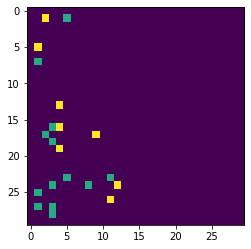

In [ ]:
from IPython.display import clear_output
for i in range(epochs):
  done = False
  while not done: 
    acts_1, act_means1, qvals1, obs_small_1, ids_1 = team_step(team1,params[0], acts_1,layers) #利用team_step( )搜集環境資料，並執行DQN來為每位代理人選擇動作
    env.set_action(team1, acts_1.detach().numpy().astype(np.int32)) #在環境中，將所選擇的動作實例化
    acts_2, act_means2, qvals2, obs_small_2, ids_2 = team_step(team2,params[0], acts_2,layers)
    env.set_action(team2, acts_2.detach().numpy().astype(np.int32))
    done = env.step() #在環境中，往前推進一步遊戲，進而產生新的觀測資料與回饋值
    _, _, qnext1, _, ids_1 = team_step(team1,params[0],acts_1,layers) #重新執行一次team_step以取得環境新狀態的Q值
    _, _, qnext2, _, ids_2 = team_step(team2,params[0],acts_2,layers)
    rewards1 = torch.from_numpy(env.get_reward(team1)).float() #將每位代理人的回饋值儲存至張量中
    rewards2 = torch.from_numpy(env.get_reward(team2)).float()

###程式 9.22
    replay1 = add_to_replay(replay1, obs_small_1, acts_1,rewards1,act_means1,qnext1) #將資料加入經驗池
    replay2 = add_to_replay(replay2, obs_small_2, acts_2,rewards2,act_means2,qnext2)     
    shuffle(replay1) #將回放緩衝區中的經驗順序打亂
    shuffle(replay2)        
    ids_1_ = list(zip(np.arange(ids_1.shape[0]),ids_1)) #建立一個代理人索引（ID）資料的壓縮串列，以便追蹤哪些代理人已經陣亡
    ids_2_ = list(zip(np.arange(ids_2.shape[0]),ids_2))        
    env.clear_dead() #將陣亡的代理人從方格板上清除        
    ids_1  = env.get_agent_id(team1) #由於陣亡代理人已經移除，重新取得存活代理人的ID，並以串列儲存
    ids_2  = env.get_agent_id(team2)        
    ids_1_ = [i for (i,j) in ids_1_ if j in ids_1] #根據尚存活的代理人ID，將舊的ID串列分割成子集
    ids_2_ = [i for (i,j) in ids_2_ if j in ids_2]        
    acts_1 = acts_1[ids_1_] #根據尚存活的代理人ID，將動作串列切割成子集
    acts_2 = acts_2[ids_2_]        
    step_ct += 1
    if step_ct > 250:
      break            
    if len(replay1) > batch_size and len(replay2) > batch_size: #當回放緩衝區內有足夠數量的資料時，開啟訓練程序
      loss1 = train(batch_size,replay1,params[0],layers=layers,J=N1)
      loss2 = train(batch_size,replay2,params[1],layers=layers,J=N1)
      losses1.append(loss1)
      losses2.append(loss2)

#小編補充：視覺化遊戲過程###
  print("Training epochs: ",i,"\nTeam 1 left: ",len(ids_1_),"\nTeam 2 left: ",len(ids_2_))  
  if(len(ids_1_)==0):
    print("Team 2 won!")
    break
  if(len(ids_2_)==0):
    print("Team 1 won!")
    break
  plt.pause(0.001)
  plt.imshow(env.get_global_minimap(30,30)[:,:,:].sum(axis=2))
  clear_output(wait=True)
